In [1]:
import cv2
import imutils
from matplotlib import pyplot as plt
#from __future__ import print_function
from imutils.object_detection import non_max_suppression
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import time
import os


In [4]:
def PersonDetectorHOG(imagepath):
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    image=cv2.imread(imagepath)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #print("Shape before resizing is{}".format(image.shape))
    image = imutils.resize(image, width=min(400, image.shape[1]))
    #print("Shape after resizing is{}".format(image.shape))
    orig = image.copy()
    fig = plt.figure()
    plt.figure(figsize=(20,10)) 
    plt.subplot(3, 1, 1)
    plt.title("Original Image")
    plt.imshow(orig)
    (rects, weights) = hog.detectMultiScale(image, winStride=(2, 2),padding=(8, 8), scale=1.01)
    #print("Total rects found {}".format(len(rects)))
    #print("Weights of the rect {}".format(weights))
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)
    plt.subplot(3, 1, 2)
    plt.title("Before NMS")
    plt.imshow(orig)
    
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
    # draw the final bounding boxes
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
    plt.subplot(3, 1, 3)
    plt.title("After NMS")
    plt.imshow(image)
    
    
    
    
    
    

<Figure size 432x288 with 0 Axes>

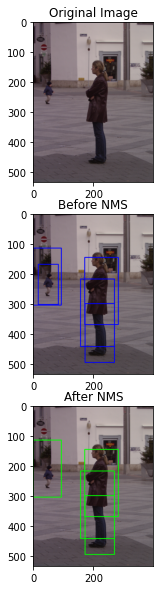

<Figure size 432x288 with 0 Axes>

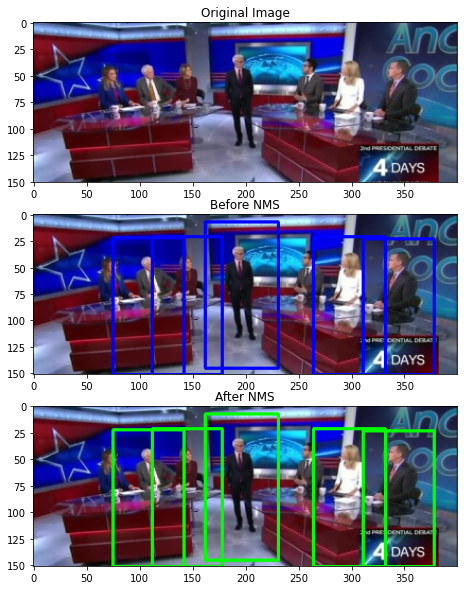

<Figure size 432x288 with 0 Axes>

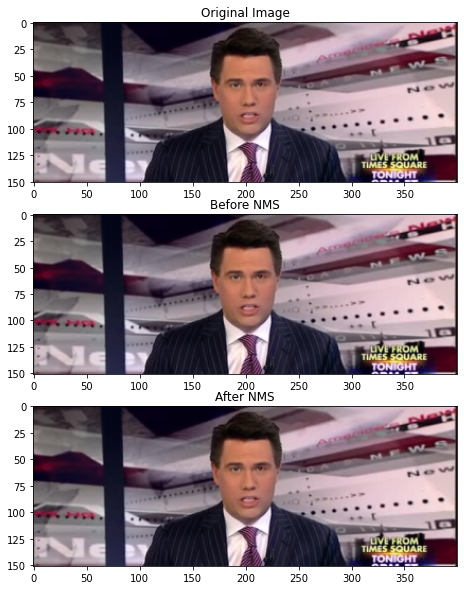

<Figure size 432x288 with 0 Axes>

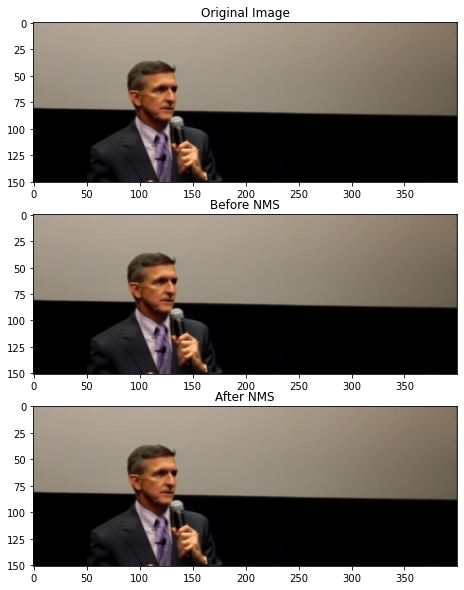

<Figure size 432x288 with 0 Axes>

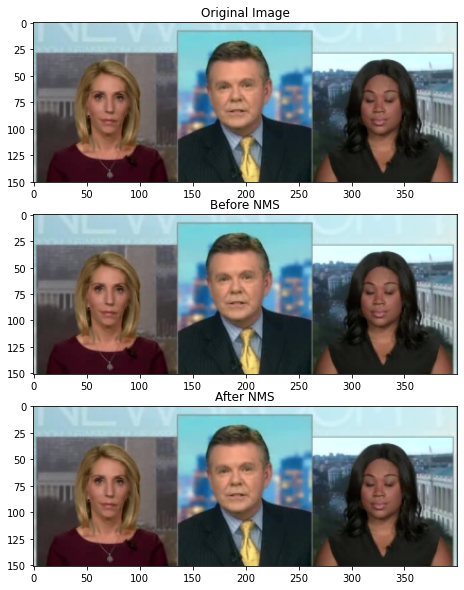

<Figure size 432x288 with 0 Axes>

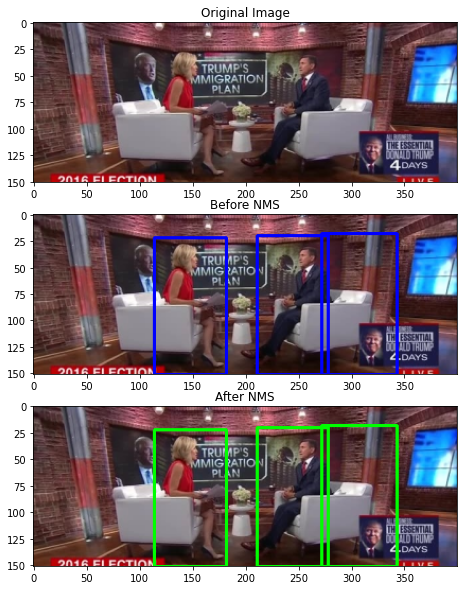

In [5]:
imagePath="person_010.bmp"
filepaths=['person_010.bmp','clip_584.jpg','clip_1.jpg','clip_6.jpg','clip_43.jpg','clip_826.jpg']
for imagePath in filepaths:
    PersonDetectorHOG(imagePath)
    #time.sleep(2)

In [8]:
#mobilessd object detection 
#image_path="clip_1.jpg"
#1.https://www.pyimagesearch.com/2017/09/11/object-detection-with-deep-learning-and-opencv/
def mobileNetSSD(image_path,threshold_confidence=0.10):
    #threshold_confidence=0.10
    prototxt_file="object-detection-deep-learning/object-detection-deep-learning/MobileNetSSD_deploy.prototxt.txt"
    caffee_model="object-detection-deep-learning/object-detection-deep-learning/MobileNetSSD_deploy.caffemodel"
    CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable","dog", "horse", "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]
    
    #Reading the image
    image=cv2.imread(image_path)

    net = cv2.dnn.readNetFromCaffe(prototxt_file,caffee_model)
    fig = plt.figure()
    plt.figure(figsize=(20,10)) 
    plt.subplot(3, 1, 1)
    plt.title("Original Image")
    plt.imshow(image)



    #len(CLASSES),len(COLORS)
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843,(300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if(confidence>threshold_confidence):

            class_label_index=int(detections[0,0,i,1])
            #print("Class label found {}".format(CLASSES[class_label_index]))
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            #interested in detecting only the person class here 
            if(CLASSES[class_label_index]=="person"):
                #print("rec")
                cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

    plt.subplot(3,1,2)
    plt.imshow(image)
    #cropping the image if needed 
    #image4=image[startY:endY,startX:endX]
    #plt.imshow(image4)
            
            
        
        


<Figure size 432x288 with 0 Axes>

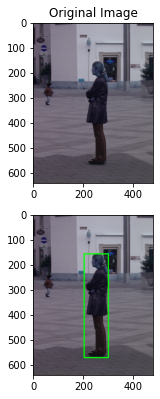

<Figure size 432x288 with 0 Axes>

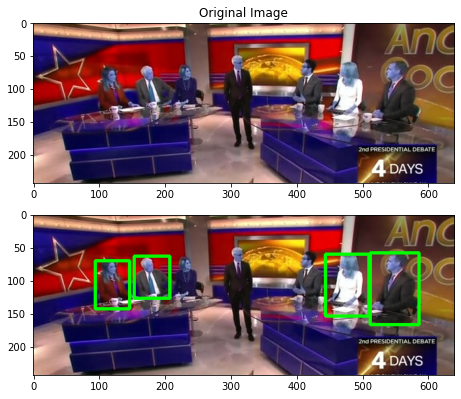

<Figure size 432x288 with 0 Axes>

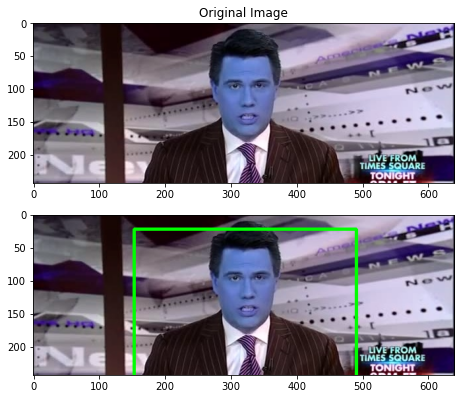

<Figure size 432x288 with 0 Axes>

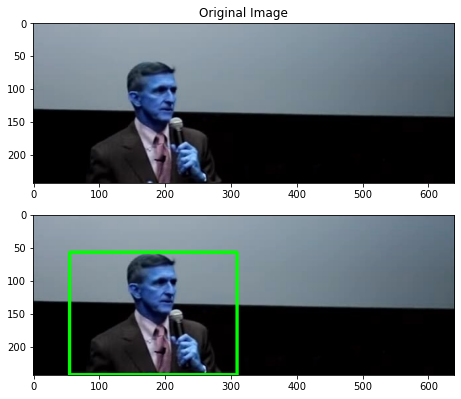

<Figure size 432x288 with 0 Axes>

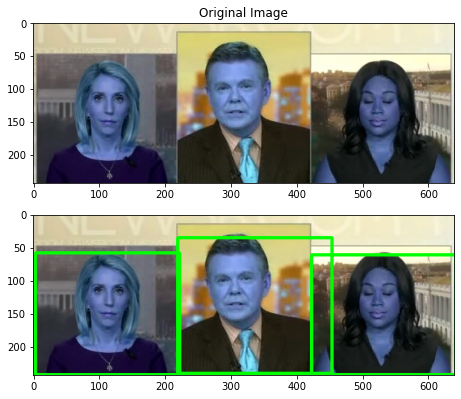

<Figure size 432x288 with 0 Axes>

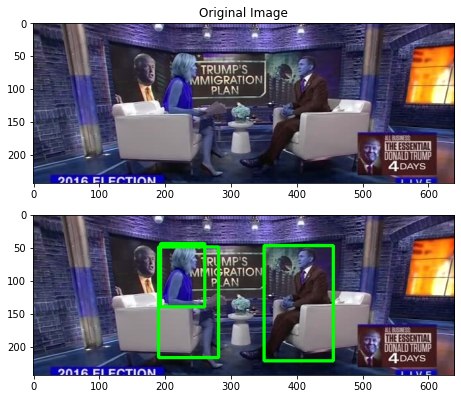

In [9]:
filepaths=['person_010.bmp','clip_584.jpg','clip_1.jpg','clip_6.jpg','clip_43.jpg','clip_826.jpg']
for imagePath in filepaths:
    mobileNetSSD(imagePath,0.2)
    #time.sleep(2)

In [10]:
#trying the yolo method 

def yolo(image_path,threshold_confidence=0.5,threshold=0.3,visualize=True):
    #threshold_confidence=0.5
    #threshold=0.3
    
    label_file_path='yolo-object-detection/yolo-object-detection/yolo-coco/coco.names'
    weights_path='yolo-object-detection/yolo-object-detection/yolo-coco/yolov3.weights'
    config_path='yolo-object-detection/yolo-object-detection/yolo-coco/yolov3.cfg'
    
    with open(label_file_path,'r')as f:
        labels=f.read().split('\n')
    #print("Total labels {} present".format(len(labels)))
    
    person_detected=False
    person_coordinates=[]
    
    net = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    image=cv2.imread(image_path)
    
    if(visualize):
        fig = plt.figure()
        plt.figure(figsize=(20,10)) 
        plt.subplot(3, 1, 1)
        plt.title("Original Image")
        plt.imshow(image)
    
    (h,w)=image.shape[:2]
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores=detection[5:]
            class_label_id=np.argmax(scores)
            confidence=scores[class_label_id]
            if(confidence>threshold_confidence):
                box=detection[0:4]*np.array([w,h,w,h])
                (centerx,centery,width,height)=box.astype("int")
                x=int(centerx-(width/2))
                y=int(centery-(height/2))
                boxes.append([x,y,int(width),int(height)])
                confidences.append(float(confidence))
                classIDs.append(class_label_id)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences,threshold_confidence,threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            if(labels[classIDs[i]]=="person"):
                person_detected=True
                #cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 2)
                person_coordinates.append([x,y,x+w,y+h])
                
                
            #print(labels[classIDs[i]])
    
    if(visualize):
        plt.subplot(3,1,2)
        plt.title("Person detection")
        plt.imshow(image)
    
    return person_coordinates,person_detected



<Figure size 432x288 with 0 Axes>

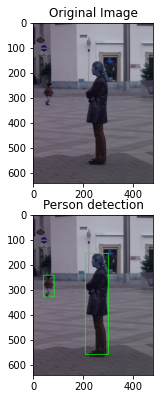

<Figure size 432x288 with 0 Axes>

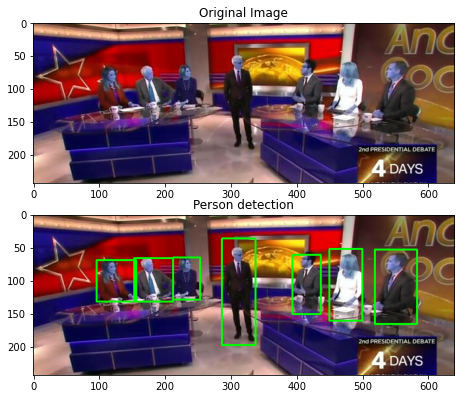

<Figure size 432x288 with 0 Axes>

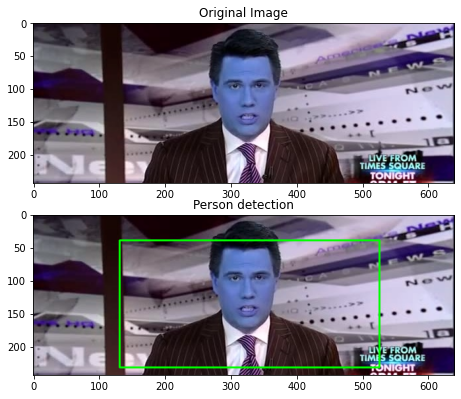

<Figure size 432x288 with 0 Axes>

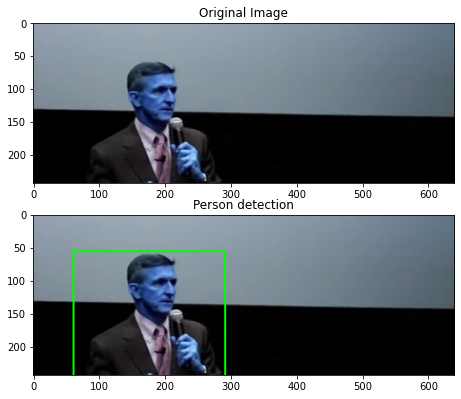

<Figure size 432x288 with 0 Axes>

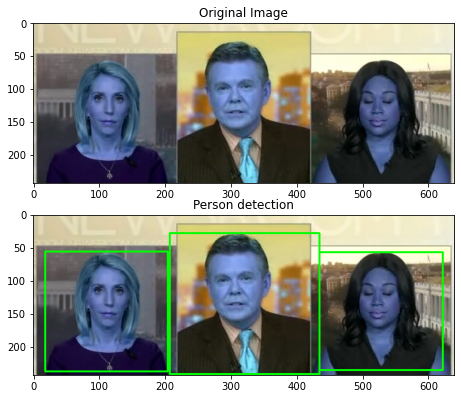

<Figure size 432x288 with 0 Axes>

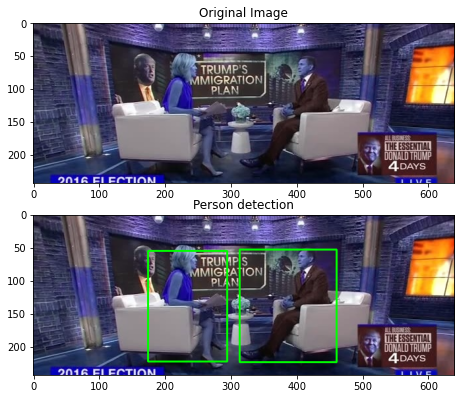

In [11]:
filepaths=['person_010.bmp','clip_584.jpg','clip_1.jpg','clip_6.jpg','clip_43.jpg','clip_826.jpg']
for imagePath in filepaths:
    a,b=yolo(imagePath,0.8,0.3)
    #time.sleep(2)

In [ ]:
def updateCoordinates(image,coordinates):
    h,w=image.shape[:2]
    startX=coordinates[0]
    startY=coordinates[1]
    endX=coordinates[2]
    endY=coordinates[3]
    if(startX-25>=0):
        startX=startX-25
    else:
        startX=0
    
    if(endX+25<=w):
        endX=endX+25
    else:
        endX=w
    
    
    if(startY-25>=0):
        startY=startY-25
    
    else:
        startY=0
    
    if(endY+35<=h):
        endY=endY+35
    
    else:
        endY=0
    
    return startX,endX,startY,endY

    
    
    
    

In [14]:
def Sort(sub_li): 
    return(sorted(sub_li, key = lambda x: x[0]))   

In [15]:
def updateImageDimensions(all_images,height,width):
    dim=(width,height)
    updated_images=[]
    for image in all_images:
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        updated_images.append(resized)
    return updated_images
        
        
        

In [16]:
def concatenateImages(updated_images):
    if(len(updated_images)>=2):
        image_concatenated=updated_images[0]
        for image in updated_images[1:]:
            image_concatenated = np.concatenate((image_concatenated, image), axis=1)
    
        return image_concatenated
    else:
        
        pass
            

<Figure size 432x288 with 0 Axes>

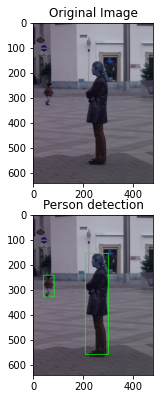

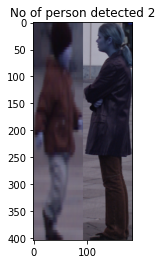

<Figure size 432x288 with 0 Axes>

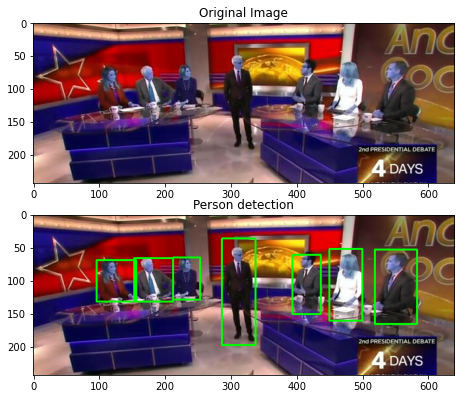

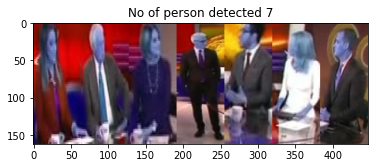

<Figure size 432x288 with 0 Axes>

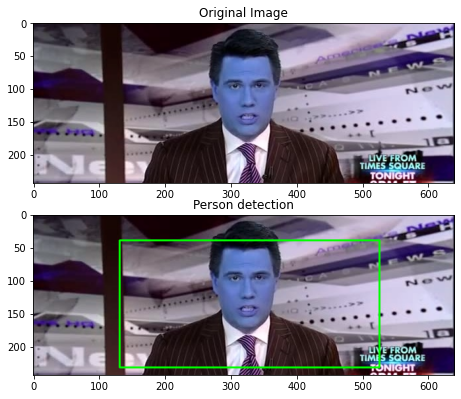

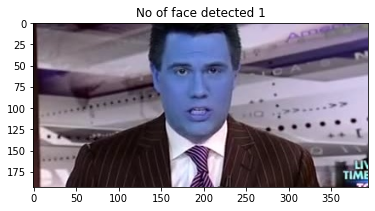

<Figure size 432x288 with 0 Axes>

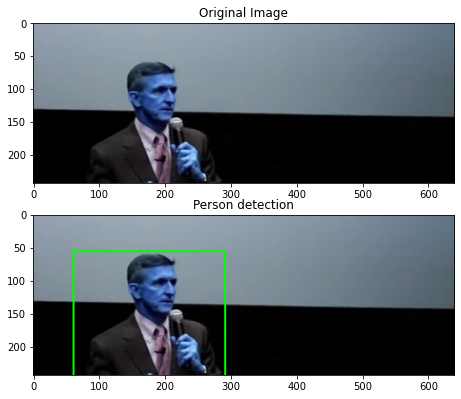

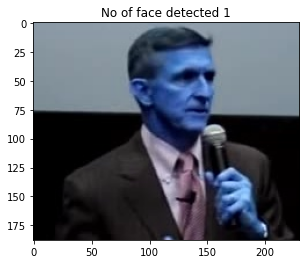

<Figure size 432x288 with 0 Axes>

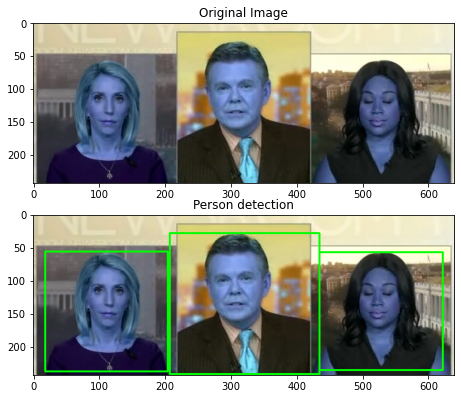

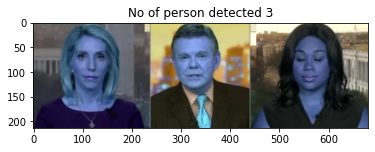

<Figure size 432x288 with 0 Axes>

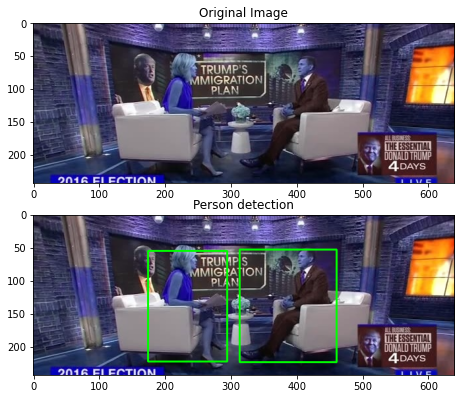

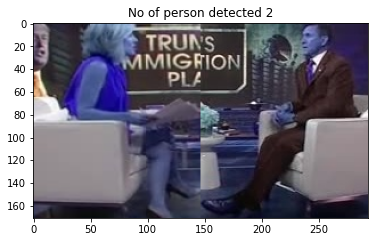

In [18]:
filepaths=['person_010.bmp','clip_584.jpg','clip_1.jpg','clip_6.jpg','clip_43.jpg','clip_826.jpg']
#filepaths=["autoencoder-image-clustering\\ideology_image_dataset\\clip_1056.jpg"]
for imagePath in filepaths:
    image=cv2.imread(imagePath)
    person_coordinates,person_detected=yolo(imagePath,0.8,0.3)
    person_coordinates=Sort(person_coordinates)
    #filename=os.path.join("ideology_person_dataset",imagePath.split("\\")[2])
    #print(filename)
    #print("Person coordinates ",person_coordinates)
    fig = plt.figure()
    if(person_detected):
        if(len(person_coordinates)>=2):
            no_person_detected=len(person_coordinates)
            all_images=[]
            max_w=0
            max_h=0
            for person_coordinate in person_coordinates:
                startX,startY,endX,endY=person_coordinate[0],person_coordinate[1],person_coordinate[2],person_coordinate[3]
                #print(startX,endX,startY,endY)
                if(startX>=0 and startY>=0 and endX>=0 and endY>=0):
                    new_image=image[startY:endY,startX:endX]
                    all_images.append(new_image)
                    h,w=new_image.shape[:2]
                   # print("new image",new_image.shape)
                    max_w=max(max_w,w)
                    max_h=max(max_h,h)
            
           # print(max_w,max_h)
            updated_images=updateImageDimensions(all_images,max_h,max_w)
            #print(updated_images[0].shape,updated_images[1].shape)
            image_concatenated=concatenateImages(updated_images)
            #print(image_concatenated.shape)
            plt.title("No of person detected %i"%no_person_detected)
            plt.imshow(image_concatenated)
            #try:
            #    cv2.imwrite(filename,image_concatenated)
            
            #except:
            #    cv2.imwrite(filename,image)
            #    pass
            
        else:
            no_person_detected=len(person_coordinates)
            person_coordinate=person_coordinates[0]
            startX,startY,endX,endY=person_coordinate[0],person_coordinate[1],person_coordinate[2],person_coordinate[3]
            if(startX>=0 and startY>=0 and endX>=0 and endY>=0):
                new_image=image[startY:endY,startX:endX]
            plt.title("No of face detected %i"%no_person_detected)
            plt.imshow(new_image)
           # try:
           #     cv2.imwrite(filename,new_image)
           # except:
           #     cv2.imwrite(filename,image)
           #     pass
                
    
    else:
        no_person_detected=0
        plt.title("No of face detected %i"%no_person_detected)

        plt.imshow(image)
        
       # cv2.imwrite(filename,image)
                

            
    
    
    #time.sleep(2)

In [45]:
files=list(os.listdir('autoencoder-image-clustering\\ideology_image_dataset'))

In [46]:
filepaths=[os.path.join('autoencoder-image-clustering\\ideology_image_dataset',file) for file in files]

In [47]:
filepaths[0].split("\\")[2],len(filepaths)

('clip_1.jpg', 2942)

In [40]:
files=list(os.listdir('ideology_person_dataset/'))
filepaths=[os.path.join('ideology_person_dataset/',file) for file in files[0:100]]
filepaths

['ideology_person_dataset/clip_1.jpg',
 'ideology_person_dataset/clip_10.jpg',
 'ideology_person_dataset/clip_100.jpg',
 'ideology_person_dataset/clip_1000.jpg',
 'ideology_person_dataset/clip_1001.jpg',
 'ideology_person_dataset/clip_1002.jpg',
 'ideology_person_dataset/clip_1003.jpg',
 'ideology_person_dataset/clip_1004.jpg',
 'ideology_person_dataset/clip_1005.jpg',
 'ideology_person_dataset/clip_1006.jpg',
 'ideology_person_dataset/clip_1007.jpg',
 'ideology_person_dataset/clip_1008.jpg',
 'ideology_person_dataset/clip_1009.jpg',
 'ideology_person_dataset/clip_101.jpg',
 'ideology_person_dataset/clip_1010.jpg',
 'ideology_person_dataset/clip_1011.jpg',
 'ideology_person_dataset/clip_1012.jpg',
 'ideology_person_dataset/clip_1013.jpg',
 'ideology_person_dataset/clip_1014.jpg',
 'ideology_person_dataset/clip_1015.jpg',
 'ideology_person_dataset/clip_1016.jpg',
 'ideology_person_dataset/clip_1017.jpg',
 'ideology_person_dataset/clip_1018.jpg',
 'ideology_person_dataset/clip_1019.jpg',

In [26]:
image=cv2.imread("ideology_person_dataset/clip_1000.jpg")
image.shape
    
resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
    

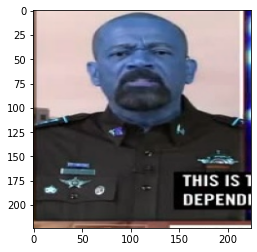

In [27]:
plt.imshow(resized)